In [1]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import os
import time
import skimage.measure
import subprocess
import random
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from sklearn.neighbors import KDTree

from mayavi import mlab
import plyfile
from pyntcloud import PyntCloud
from plyfile import PlyData
from chamfer_distance import 

import deep_sdf
import deep_sdf.workspace as ws
from reconstruct import reconstruct

SyntaxError: invalid syntax (<ipython-input-1-9fcbbc4c2cc5>, line 22)

In [84]:
def create_mesh(
    decoder, latent_vec, filename='', N=256, max_batch=32 ** 3, offset=None, scale=None
):
    start = time.time()
    ply_filename = filename

    decoder.eval()

    # NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
    voxel_origin = [-1, -1, -1]
    voxel_size = 2.0 / (N - 1)

    overall_index = torch.arange(0, N ** 3, 1, out=torch.LongTensor())
    samples = torch.zeros(N ** 3, 4)

    # transform first 3 columns
    # to be the x, y, z index
    samples[:, 2] = overall_index % N
    samples[:, 1] = (overall_index.long() / N) % N
    samples[:, 0] = ((overall_index.long() / N) / N) % N

    # transform first 3 columns
    # to be the x, y, z coordinate
    samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
    samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
    samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

    num_samples = N ** 3

    samples.requires_grad = False

    head = 0

    while head < num_samples:
        sample_subset = samples[head : min(head + max_batch, num_samples), 0:3].cuda()

        samples[head : min(head + max_batch, num_samples), 3] = (
            deep_sdf.utils.decode_sdf(decoder, latent_vec, sample_subset)
            .squeeze(1)
            .detach()
            .cpu()
        )
        head += max_batch

    sdf_values = samples[:, 3]
    sdf_values = sdf_values.reshape(N, N, N)

    end = time.time()
    print("sampling takes: %f" % (end - start))

    return convert_sdf_samples_to_ply(
        sdf_values.data.cpu(),
        voxel_origin,
        voxel_size,
        ply_filename + ".ply",
        offset,
        scale,
    )


def convert_sdf_samples_to_ply(
    pytorch_3d_sdf_tensor,
    voxel_grid_origin,
    voxel_size,
    ply_filename_out,
    offset=None,
    scale=None,
):
    """
    Convert sdf samples to .ply

    :param pytorch_3d_sdf_tensor: a torch.FloatTensor of shape (n,n,n)
    :voxel_grid_origin: a list of three floats: the bottom, left, down origin of the voxel grid
    :voxel_size: float, the size of the voxels
    :ply_filename_out: string, path of the filename to save to

    This function adapted from: https://github.com/RobotLocomotion/spartan
    """
    start_time = time.time()

    numpy_3d_sdf_tensor = pytorch_3d_sdf_tensor.numpy()

    verts, faces, normals, values = skimage.measure.marching_cubes_lewiner(
        numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3
    )

    # transform from voxel coordinates to camera coordinates
    # note x and y are flipped in the output of marching_cubes
    mesh_points = np.zeros_like(verts)
    mesh_points[:, 0] = voxel_grid_origin[0] + verts[:, 0]
    mesh_points[:, 1] = voxel_grid_origin[1] + verts[:, 1]
    mesh_points[:, 2] = voxel_grid_origin[2] + verts[:, 2]

    # apply additional offset and scale
    if scale is not None:
        mesh_points = mesh_points / scale
    if offset is not None:
        mesh_points = mesh_points - offset

    # try writing to the ply file

    num_verts = verts.shape[0]
    num_faces = faces.shape[0]

    verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

    for i in range(0, num_verts):
        verts_tuple[i] = tuple(mesh_points[i, :])

    faces_building = []
    for i in range(0, num_faces):
        faces_building.append(((faces[i, :].tolist(),)))
    faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

    el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
    el_faces = plyfile.PlyElement.describe(faces_tuple, "face")

    ply_data = plyfile.PlyData([el_verts, el_faces])
    return ply_data


def process_mesh(mesh_filepath, target_filepath, executable, additional_args):
    my_env = os.environ.copy()
    my_env["PANGOLIN_WINDOW_URI"] = "headless://"
    
    command = [executable, "-m", mesh_filepath, "-o", target_filepath] + additional_args

    subproc = subprocess.Popen(command, stdout=subprocess.DEVNULL, stderr=subprocess.PIPE, env=my_env)
    subproc.wait()
    
    out, err = subproc.communicate()
    if out is not None:
        print(out.decode())
    if err is not None:
        print(err.decode())

## Prepare model

In [85]:
def load_model(experiment_directory, checkpoint):
    specs_filename = os.path.join(experiment_directory, "specs.json")

    if not os.path.isfile(specs_filename):
        raise Exception(
            'The experiment directory does not include specifications file "specs.json"'
        )

    specs = json.load(open(specs_filename))

    arch = __import__("networks." + specs["NetworkArch"], fromlist=["Decoder"])

    latent_size = specs["CodeLength"]

    decoder = arch.Decoder(latent_size, **specs["NetworkSpecs"])

    decoder = torch.nn.DataParallel(decoder)

    saved_model_state = torch.load(
        os.path.join(experiment_directory, ws.model_params_subdir, checkpoint + ".pth")
    )
    saved_model_epoch = saved_model_state["epoch"]

    decoder.load_state_dict(saved_model_state["model_state_dict"])

    decoder = decoder.module.cuda()

    decoder.eval()
    
    return decoder

In [86]:
experiment_directory = "/cvlabdata2/home/artem/DeepSDF/examples/sofas/"
checkpoint = "latest"

decoder = load_model(experiment_directory, checkpoint)

## Load latent vectors

In [87]:
latent_vectors = ws.load_latent_vectors(experiment_directory, checkpoint)
latent_size = latent_vectors[0].size()[1]
print(f"{len(latent_vectors)} of latent vectors, each {latent_size} long")

1628 of latent vectors, each 256 long


## Generate mesh

In [88]:
initial_vector = latent_vectors[356]

In [89]:
ply_mesh = None

with torch.no_grad():
    ply_mesh = create_mesh( decoder,
                            initial_vector,
                            N=256,
                            max_batch=int(2 ** 18),
                            offset=None,
                            scale=None)
ply_mesh.write('../Expirements/data/original_mesh.ply')

sampling takes: 40.074510


In [90]:
cloud = PyntCloud.from_file('../Expirements/data/original_mesh.ply')
cloud.plot(background='white', initial_point_size=0.003)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.0016829955857247114, 0.4273731996072456, …

In [ ]:
cloud

## Change mesh a bit

In [ ]:
verts, faces = plyfile.PlyData.read('../Expirements/data/original_mesh.ply').elements

for i in range(0, len(verts.data)):
    x, y, z = verts.data[i]
    verts.data[i] = (2 * x, y, z)

changed_ply_data = plyfile.PlyData([verts, faces])
changed_ply_data.write('../Expirements/data/changed_mesh.ply')

In [91]:
changed_cloud = PyntCloud.from_file('../Expirements/data/changed_mesh.ply')
changed_cloud.plot(background='white', initial_point_size=0.003)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.003365991171449423, 0.4273731996072456, 0…

In [ ]:
changed_cloud

## Generate a new vector

In [ ]:
process_mesh('../Expirements/data/changed_mesh.ply', '../Expirements/data/changed_mesh_SDF.npz', 
             'bin/PreprocessMesh', [])

In [ ]:
data_sdf = deep_sdf.data.read_sdf_samples_into_ram('../Expirements/data/changed_mesh_SDF.npz')
data_sdf[0] = data_sdf[0][torch.randperm(data_sdf[0].shape[0])]
data_sdf[1] = data_sdf[1][torch.randperm(data_sdf[1].shape[0])]

In [ ]:
err, latent = reconstruct(
                decoder,
                800,
                latent_size,
                data_sdf,
                0.01,  # [emp_mean,emp_var],
                0.1,
                num_samples=8000,
                lr=5e-3,
                l2reg=True,
            )

In [ ]:
initial_vector - latent

In [ ]:
reconstructed_ply_mesh = None

with torch.no_grad():
    reconstructed_ply_mesh = create_mesh( decoder,
                            latent,
                            N=256,
                            max_batch=int(2 ** 18),
                            offset=None,
                            scale=None)
reconstructed_ply_mesh.write('../Expirements/data/reconstucted_mesh.ply')

In [92]:
changed_cloud = PyntCloud.from_file('../Expirements/data/reconstucted_mesh.ply')
changed_cloud.plot(background='white', initial_point_size=0.003)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.006710517220199108, 0.21170878782868385, …

## Lets check impossible shape

In [95]:
verts, faces = plyfile.PlyData.read('../Expirements/data/original_mesh.ply').elements

for i in range(0, len(verts.data)):
    x, y, z = verts.data[i]
    if x > 0:
        verts.data[i] = (x, y + 0.02, z)

changed_ply_data = plyfile.PlyData([verts, faces])
changed_ply_data.write('../Expirements/data/changed_mesh2.ply')

In [96]:
changed_cloud = PyntCloud.from_file('../Expirements/data/changed_mesh2.ply')
changed_cloud.plot(background='white', initial_point_size=0.003)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.0016829955857247114, 0.45731561724096537,…

In [ ]:
process_mesh('../Expirements/data/changed_mesh2.ply', '../Expirements/data/changed_mesh_SDF2.npz', 
             'bin/PreprocessMesh', [])

In [ ]:
data_sdf = deep_sdf.data.read_sdf_samples_into_ram('../Expirements/data/changed_mesh_SDF2.npz')
data_sdf[0] = data_sdf[0][torch.randperm(data_sdf[0].shape[0])]
data_sdf[1] = data_sdf[1][torch.randperm(data_sdf[1].shape[0])]

In [ ]:
err, latent2 = reconstruct(
                decoder,
                800,
                latent_size,
                data_sdf,
                0.01,  # [emp_mean,emp_var],
                0.1,
                num_samples=8000,
                lr=5e-3,
                l2reg=True,
            )

In [ ]:
reconstructed_ply_mesh = None

with torch.no_grad():
    reconstructed_ply_mesh = create_mesh( decoder,
                            latent2,
                            N=256,
                            max_batch=int(2 ** 18),
                            offset=None,
                            scale=None)
reconstructed_ply_mesh.write('../Expirements/data/reconstucted_mesh2.ply')

In [80]:
changed_cloud = PyntCloud.from_file('../Expirements/data/reconstucted_mesh2.ply')
changed_cloud.plot(background='white', initial_point_size=0.003)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.002175437519326806, 0.36393335834145546, …

## Noisy sofa?

In [97]:
verts, faces = plyfile.PlyData.read('../Expirements/data/original_mesh.ply').elements

for i in range(0, len(verts.data)):
    x, y, z = verts.data[i]
    x += random.random() / 30
    y += random.random() / 30
    z += random.random() / 30
    verts.data[i] = (x, y, z)

changed_ply_data = plyfile.PlyData([verts, faces])
changed_ply_data.write('../Expirements/data/changed_mesh3.ply')

In [98]:
changed_cloud = PyntCloud.from_file('../Expirements/data/changed_mesh3.ply')
changed_cloud.plot(background='white', initial_point_size=0.003)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.014982783235609531, 0.47701494954526424, 0…

In [56]:
process_mesh('../Expirements/data/changed_mesh3.ply', '../Expirements/data/changed_mesh_SDF3.npz', 
             'bin/PreprocessMesh', [])

OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203



In [57]:
data_sdf = deep_sdf.data.read_sdf_samples_into_ram('../Expirements/data/changed_mesh_SDF3.npz')
data_sdf[0] = data_sdf[0][torch.randperm(data_sdf[0].shape[0])]
data_sdf[1] = data_sdf[1][torch.randperm(data_sdf[1].shape[0])]

err, latent3 = reconstruct(
                decoder,
                800,
                latent_size,
                data_sdf,
                0.01,  # [emp_mean,emp_var],
                0.1,
                num_samples=8000,
                lr=5e-3,
                l2reg=True,
            )

In [58]:
reconstructed_ply_mesh = None

with torch.no_grad():
    reconstructed_ply_mesh = create_mesh( decoder,
                            latent3,
                            N=256,
                            max_batch=int(2 ** 18),
                            offset=None,
                            scale=None)
reconstructed_ply_mesh.write('../Expirements/data/reconstucted_mesh3.ply')

KeyboardInterrupt: 

In [99]:
changed_cloud = PyntCloud.from_file('../Expirements/data/reconstucted_mesh3.ply')
changed_cloud.plot(background='white', initial_point_size=0.003)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.0036463269498199224, 0.35841766744852066, …

In [6]:
def make_one_optimization_step(initial_vector, decoder, change_func, N=256, num_of_iterations=800, 
                               ex_prefix='', debug=False):
    # Generate original mesh
    ply_mesh = None

    with torch.no_grad():
        ply_mesh = create_mesh( decoder,
                                torch.cuda.FloatTensor(initial_vector),
                                N=N,
                                max_batch=int(2 ** 18),
                                offset=None,
                                scale=None)

    vertexes, _ = ply_mesh
    print("Sampled ", len(vertexes.data), " points")
        
    ORIGINAL_PATH = '../Expirements/data/'+ ex_prefix + '_original.ply'
    
    if debug:
        ply_mesh.write(ORIGINAL_PATH)


    # Change the mesh
    changed_ply_data = change_func(ply_mesh)

    CHANGED_PATN = '../Expirements/data/'+ ex_prefix + '_changed.ply'
    changed_ply_data.write(CHANGED_PATN)

    # Reconstruct
    process_mesh(CHANGED_PATN, CHANGED_PATN[:-4] + '.npz', 'bin/PreprocessMesh', [])
    if debug:
        print("Mesh is processed")
    data_sdf = deep_sdf.data.read_sdf_samples_into_ram(CHANGED_PATN[:-4] + '.npz')
    data_sdf[0] = data_sdf[0][torch.randperm(data_sdf[0].shape[0])]
    data_sdf[1] = data_sdf[1][torch.randperm(data_sdf[1].shape[0])]
    
    err, latent2 = reconstruct(
                decoder,
                num_of_iterations,
                latent_size,
                data_sdf,
                0.01,  # [emp_mean,emp_var],
                0.1,
                num_samples=8000,
                lr=5e-3,
                l2reg=True,
                initial_latent=initial_vector
            )
    
    reconstructed_ply_mesh = None
    
    if debug:
        print("Mesh is reconstructed")

    with torch.no_grad():
        reconstructed_ply_mesh = create_mesh( decoder,
                                latent2,
                                N=256,
                                max_batch=int(2 ** 18),
                                offset=None,
                                scale=None)
    RECONSTRUCTED_PATH = '../Expirements/data/'+ ex_prefix + '_reconstructed.ply'
    if debug:
        reconstructed_ply_mesh.write(RECONSTRUCTED_PATH)

    return err, latent2, reconstructed_ply_mesh

In [7]:
def plot_ply(path):
    changed_cloud = PyntCloud.from_file(path)
    changed_cloud.plot(background='white', initial_point_size=0.003)
    
def stretch_mesh(mesh):
    verts, faces = mesh.elements

    for i in range(0, len(verts.data)):
        x, y, z = verts.data[i]
        verts.data[i] = (2 * x, y, z)

    changed_ply_data = plyfile.PlyData([verts, faces])
    return changed_ply_data;

# Sparce optimization test

In [8]:
def make_mesh_sparce_and_stretch(mesh, num_of_points=100, stretch=1):
    verts, faces = mesh.elements
    data_verts = np.array(verts.data)
    
    vertex = np.array(random.choices(data_verts, k=num_of_points),
                      dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
    
    print('Number of verts:', len(data_verts), ' -> ', len(vertex))

    for i in range(0, len(vertex)):
        x, y, z = vertex[i]
        vertex[i] = (stretch * x, y, z)
        
    face = np.array([], dtype=[('vertex_indices', 'i4', (3,)),
                                  ('red', 'u1'), ('green', 'u1'),
                                  ('blue', 'u1')])

    el_v = plyfile.PlyElement.describe(vertex, 'vertex')
    el_f = plyfile.PlyElement.describe(face, 'face')
    changed_ply_data = plyfile.PlyData([el_v, el_f])
    return changed_ply_data


def stretch_mesh(mesh, stretch=1):
    verts, faces = mesh.elements

    for i in range(0, len(verts.data)):
        x, y, z = verts.data[i]
        verts.data[i] = (stretch * x, y, z)

    return plyfile.PlyData([verts, faces])

def cast_arr(arr):
    return np.array(list(map(lambda x: (float(x[0]), float(x[1]), float(x[2])), list(arr['vertex'].data))))

def chamfer_distance(array1, array2):
    num_point = array1.shape[0]
    
    tree1 = KDTree(array1, leaf_size=num_point+1)
    tree2 = KDTree(array2, leaf_size=num_point+1)
    distances1, _ = tree1.query(array2)
    distances2, _ = tree2.query(array1)
    av_dist1 = np.mean(distances1)
    av_dist2 = np.mean(distances2)
    return (av_dist1+av_dist2) / 2

## Create reference mesh

In [10]:
ref_mesh = None

with torch.no_grad():
    ref_mesh = create_mesh( decoder,
                            latent_vectors[356],
                            N=256,
                            max_batch=int(2 ** 18),
                            offset=None,
                            scale=None)

ref_mesh = stretch_mesh(ref_mesh, stretch=1.1**5)
ref_mesh.write( '../Expirements/data/ref_mesh.ply')

sampling takes: 41.033458


## Number of optimized points = 109732

In [18]:
latent_109732  = latent_vectors[356]

for i in tqdm_notebook(range(5)):
    error_109732, latent_109732, reconstructed_ply_mesh_109732 =\
        make_one_optimization_step( latent_109732,\
                                    decoder,\
                                    lambda x: stretch_mesh(x, stretch=1.1),\
                                    N=256,\
                                    ex_prefix='s109732', debug=False,\
                                    num_of_iterations=100)

sampling takes: 41.497761
Sampled  109732  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 41.028845
sampling takes: 42.060101
Sampled  100210  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 41.276613
sampling takes: 42.443512
Sampled  97180  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 41.146491
sampling takes: 41.694294
Sampled  88246  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.777962
sampling takes: 41.650614
Sampled  82656  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.747753



In [19]:
chamfer_distance(cast_arr(reconstructed_ply_mesh_109732), cast_arr(ref_mesh))

0.09523257455147614

In [43]:
reconstructed_ply_mesh_109732.write('../Expirements/data/'+ 's109732' + '_reconstructed.ply')

## Number of optimized points = 26654

In [20]:
latent_26654  = latent_vectors[356]

for i in tqdm_notebook(range(5)):
    error_26654, latent_26654, reconstructed_ply_mesh_26654 =\
        make_one_optimization_step( latent_26654,\
                                    decoder,\
                                    lambda x: stretch_mesh(x, stretch=1.1),\
                                    N=128,\
                                    ex_prefix='s26654', debug=False,\
                                    num_of_iterations=100)

sampling takes: 5.041800
Sampled  26654  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.700509
sampling takes: 5.063262
Sampled  25124  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.698469
sampling takes: 5.068825
Sampled  23528  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 41.042753
sampling takes: 5.112397
Sampled  21518  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 41.225335
sampling takes: 5.079490
Sampled  20108  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 41.063596



In [26]:
chamfer_distance(cast_arr(reconstructed_ply_mesh_26654), cast_arr(ref_mesh))

0.09464785144708784

In [44]:
reconstructed_ply_mesh_26654.write('../Expirements/data/'+ 's26654' + '_reconstructed.ply')

## Number of optimized points = 6526 

In [27]:
latent_6526  = latent_vectors[356]

for i in tqdm_notebook(range(5)):
    error_6526, latent_6526, reconstructed_ply_mesh_6526 =\
        make_one_optimization_step( latent_6526,\
                                    decoder,\
                                    lambda x: stretch_mesh(x, stretch=1.1),\
                                    N=64,\
                                    ex_prefix='s6526', debug=False,\
                                    num_of_iterations=100)

sampling takes: 0.592110
Sampled  6526  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.246956
sampling takes: 0.609672
Sampled  6018  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.053288
sampling takes: 0.600991
Sampled  5938  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.469594
sampling takes: 0.641014
Sampled  5324  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.853557
sampling takes: 0.614305
Sampled  4924  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.815648



In [28]:
chamfer_distance(cast_arr(reconstructed_ply_mesh_6526), cast_arr(ref_mesh))

0.09456828585439989

In [45]:
reconstructed_ply_mesh_6526.write('../Expirements/data/'+ 's6526' + '_reconstructed.ply')

## Number of optimized points = 1554

In [ ]:
latent_1554 = latent_vectors[356]

for i in tqdm_notebook(range(5)):
    error_1554, latent_1554, reconstructed_ply_mesh_1554 =\
        make_one_optimization_step( latent_1554,\
                                    decoder,\
                                    lambda x: stretch_mesh(x, stretch=1.1),\
                                    N=32,\
                                    ex_prefix='s1554', debug=False,\
                                    num_of_iterations=100)

sampling takes: 0.107412
Sampled  1554  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.010346
sampling takes: 0.092682
Sampled  1444  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.330642
sampling takes: 0.093212
Sampled  1348  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.957092
sampling takes: 0.090771
Sampled  1270  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203



In [32]:
chamfer_distance(cast_arr(reconstructed_ply_mesh_1554), cast_arr(ref_mesh))

0.09339104394702974

In [46]:
reconstructed_ply_mesh_1554.write('../Expirements/data/'+ 's1554' + '_reconstructed.ply')

## Number of optimized points = 328

In [33]:
latent_328 = latent_vectors[356]

for i in tqdm_notebook(range(5)):
    error_328, latent_328, reconstructed_ply_mesh_328 =\
        make_one_optimization_step( latent_328,\
                                    decoder,\
                                    lambda x: stretch_mesh(x, stretch=1.1),\
                                    N=16,\
                                    ex_prefix='s328', debug=False,\
                                    num_of_iterations=100)

sampling takes: 0.015875
Sampled  328  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.097438
sampling takes: 0.013163
Sampled  282  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.301192
sampling takes: 0.013338
Sampled  310  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.266774
sampling takes: 0.012669
Sampled  278  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.315910
sampling takes: 0.012945
Sampled  192  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.671061



In [ ]:
chamfer_distance(cast_arr(reconstructed_ply_mesh_328), cast_arr(ref_mesh))

0.12438103998622772

In [47]:
reconstructed_ply_mesh_328.write('../Expirements/data/'+ 's328' + '_reconstructed.ply')

## Number of optimized points = 112

In [36]:
latent_64 = latent_vectors[356]

for i in tqdm_notebook(range(5)):
    error_64, latent_64, reconstructed_ply_mesh_64 =\
        make_one_optimization_step( latent_64,\
                                    decoder,\
                                    lambda x: stretch_mesh(x, stretch=1.1),\
                                    N=12,\
                                    ex_prefix='s64', debug=False,\
                                    num_of_iterations=100)

sampling takes: 0.009099
Sampled  112  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.160507
sampling takes: 0.007214
Sampled  122  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.204196
sampling takes: 0.007059
Sampled  114  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.490285
sampling takes: 0.007490
Sampled  76  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.585571
sampling takes: 0.007191
Sampled  46  points
OpenGL Error: XX (500)
In: /cvlabdata2/home/artem/DeepSDF/Pangolin/include/pangolin/gl/gl.hpp, line 203

sampling takes: 40.716996



In [48]:
chamfer_distance(cast_arr(reconstructed_ply_mesh_64), cast_arr(ref_mesh))

0.17278512304366633

In [50]:
reconstructed_ply_mesh_64.write('../Expirements/data/'+ 's112' + '_reconstructed.ply')

## Compare the results

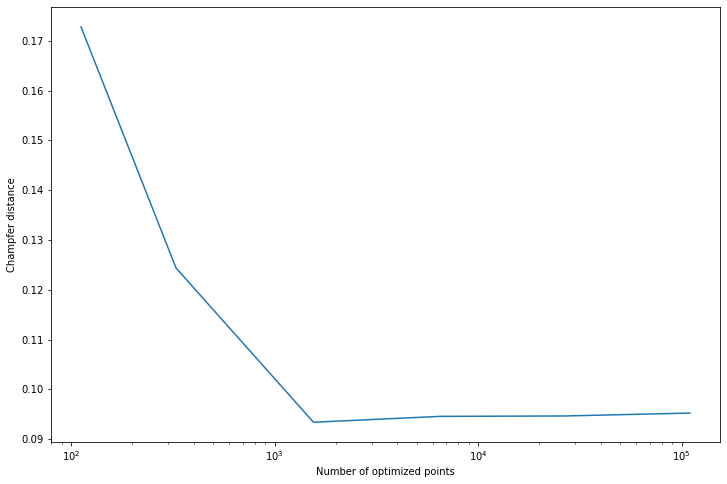

In [100]:
num_points = [109732, 26654, 6526, 1554, 328, 112]
champfer = [0.09523257455147614, 0.09464785144708784, 0.09456828585439989, 0.09339104394702974, 0.12438103998622772, 0.17278512304366633]

plt.figure(figsize=(12, 8))
plt.plot(num_points, champfer)
plt.ylabel('Champfer distance')
plt.xlabel('Number of optimized points')
plt.xscale('log')
plt.show()

In [101]:
plot_ply('../Expirements/data/ref_mesh.ply')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.002710496773943305, 0.4273731996072456, 0…

In [78]:
plot_ply('../Expirements/data/'+ 's109732' + '_reconstructed.ply')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.005478765349835157, 0.17040502279996872, 0…

In [60]:
plot_ply('../Expirements/data/'+ 's6526' + '_reconstructed.ply')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.00649914238601923, 0.16435828059911728, 0.…

In [61]:
plot_ply('../Expirements/data/'+ 's1554' + '_reconstructed.ply')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.0009058438590727746, 0.150764562189579, 0.…

In [62]:
plot_ply('../Expirements/data/'+ 's328' + '_reconstructed.ply')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.03960524499416351, 0.10296153649687767, 0…